The data is here:  
  
Addison Howard and Wendy Kan. What's Cooking? (Kernels Only). https://kaggle.com/competitions/whats-cooking-kernels-only, 2018. Kaggle.

  
This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients.   
  
# Read the data

In [4]:
import pandas as pd

In [309]:
train = pd.read_json("../datasets/whats-cooking-kernels-only/train.json")

In [310]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [311]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [312]:
train['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

There are 39774 unique recipies belonging to different cusines in the train set.  
The Ingredients for every recipe is given as a list.  
Cuisine is the target variable.  
There are recipies from 20 different Cuisines. This means that the problem at hand is a multi-class classification.


<Axes: xlabel='cuisine'>

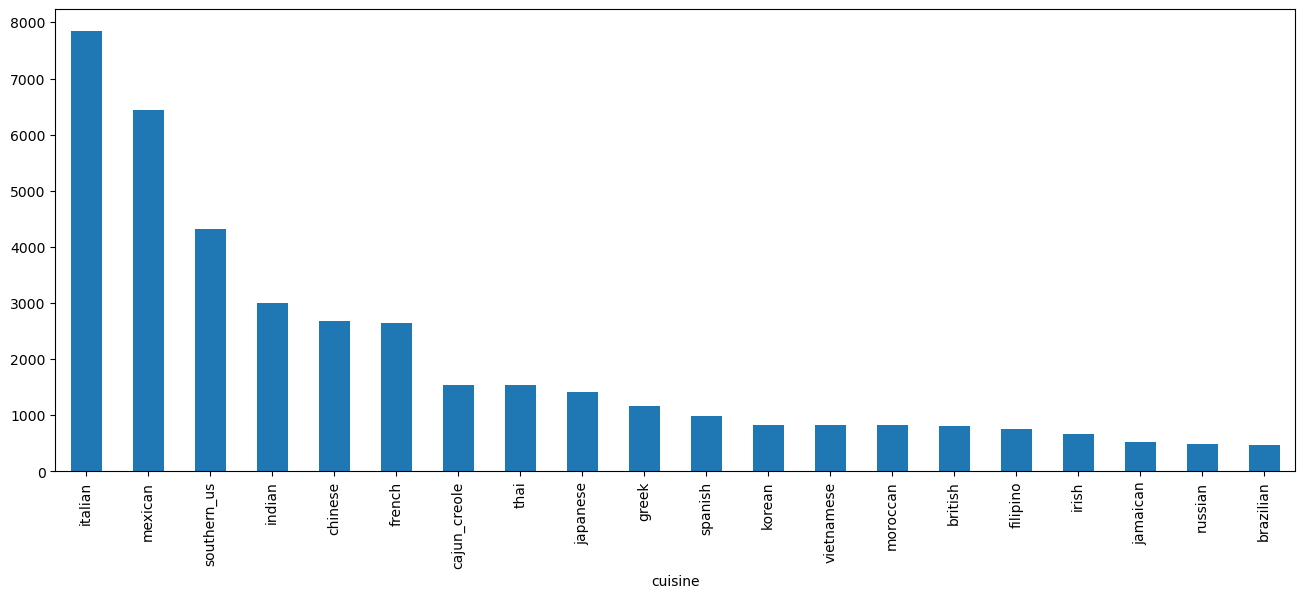

In [313]:
train['cuisine'].value_counts().plot.bar(figsize=(16,6))

From the plot of label distribution, we observe that the most common category in our sample is the Italian cuisine, followed by the Mexican. The least represented cuisines are the Irish, Jamaican, Russian and Brazilian - counting for only 6% of our training sample of recipes.

Let's count the number of ingredients used in a given recipe and add it as a column.

In [314]:
#no of Ingredients
train['num_ing'] = train['ingredients'].apply(lambda x: len(x))

<Axes: xlabel='num_ing'>

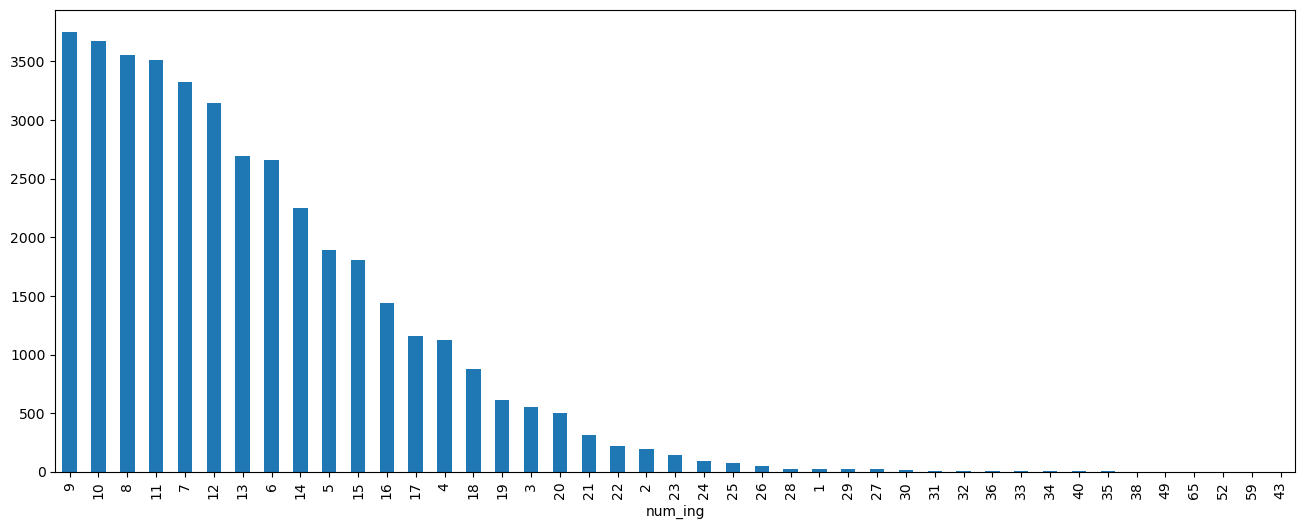

In [315]:
train['num_ing'].value_counts().plot.bar(figsize=(16,6))

The distribution of recipe length is right-skewed as we can see from the histogram above.



In [316]:
import seaborn as sns

<Axes: xlabel='cuisine', ylabel='num_ing'>

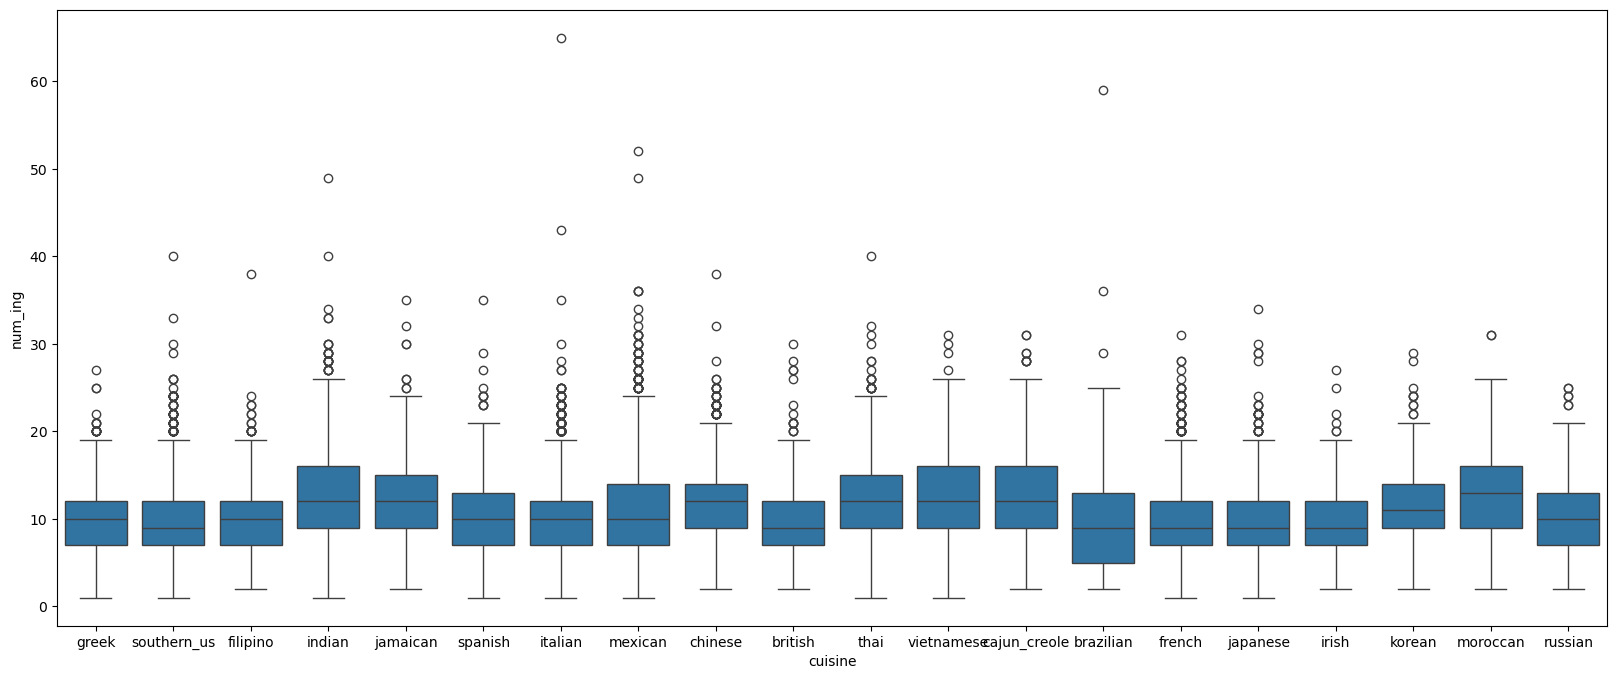

In [317]:
plt.figure(figsize=(20,8))
sns.boxplot(x='cuisine',y='num_ing',data=train)

From the box plots of recipe length distributions, we can make several observations:   
  
The Moroccan cuisine seems to have the longest recipes on average compared to all the rest cuisines in our sample.  
We observe the opposite phenomenon for the Irish, British, French and Southern_us cuisine  
There exist outliers in all cuisines  
Recipes part of the European cuisine tend to be with average length or shorter compared to the rest of the sample.

From the histogram of number of ingredients, we can see that there are (few) recipes with only one (or two) ingredients. They make less sense. Will remove them in the pre-processing.

In [318]:
result = train.query("num_ing == 1")
result.shape

(22, 4)

In [319]:
result.head(5)

,id,cuisine,ingredients,num_ing
940,4734,japanese,[sushi rice],1
2088,7833,vietnamese,[dried rice noodles],1
6787,36818,indian,[plain low-fat yogurt],1
7011,19772,indian,[unsalted butter],1
8181,16116,japanese,[udon],1


# Pre-process the data

In this section we will:  
  
- Remove outliers
- convert to lowercase
- remove hyphen
- remove numbers
- remove words which consist of less than 2 characters
- remove units
- lemmatize


In [36]:
from nltk.stem import WordNetLemmatizer
import re

In [122]:
#Removing Outliers Values that were irrevelant to model
train = train[train['num_ing'] > 1]
#train = train[train['num_ing'] > 2]
#train = train[train['num_ing']<60]
train.shape

(39752, 4)

In [43]:
lemmatizer = WordNetLemmatizer()

def preprocess(ingredients):
    ingredients_text = ' '.join(ingredients)
    ingredients_text = ingredients_text.lower() #Lower - Casing
    ingredients_text = ingredients_text.replace('-', ' ') # Removing Hyphen
    words = []
    for word in ingredients_text.split():
        word = re.sub("[0-9]"," ",word) #removing numbers,punctuations and special characters
        word = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', word) # Removing Units
        if len(word) <= 2: continue # Removing words with less than two characters
        #word = unidecode.unidecode(word) #Removing accents
        word = lemmatizer.lemmatize(word) #Lemmatize
        if len(word) > 0: words.append(word)
    return ' '.join(words)


In [154]:
#Checking if our function works
for ingredient, expected in [
    ('Eggs', 'egg'),
    ('all-purpose flour', 'all purpose flour'),
    ('1% low-fat milk', 'low fat milk'),
    ('half & half', 'half half'),
    ('safetida (powder)', 'safetida (powder)')
]:
    actual = preprocess([ingredient])
    assert actual == expected, f'"{expected}" is expected but got "{actual}"'


In [156]:
train['x'] = train['ingredients'].apply(lambda ingredients: preprocess(ingredients))
train.head()

/var/folders/8g/4xvwd0w96wg80spn6kr2rh640000gp/T/ipykernel_62729/2703667924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['x'] = train['ingredients'].apply(lambda ingredients: preprocess(ingredients))


,id,cuisine,ingredients,num_ing,x
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


In [325]:
1/20

0.05

# Baseline

Since there are 20 different types of cuisines, predicting a random one would be correct only 5% of the times.  
The simplest baseline would be to predict always it's Italian cuisine as it's the the one with most recipes. Better than random answer but it would be too crude and inaccurate: around 20% of times correct.  
We need a better model as baseline.
We will start with a simple model: a bag of words, which will act as the baseline.  
First we need to extract the word frequencies to be used in our prediction problem.

## Create a Document-Term matrix
A document-term matrix (DTM) is basically a matrix with the documents (in our case the recipes) designated by rows and the single ingredient by columns, and where the matrix elements are the counts of those ingredients in each recipe.

The scikit-learn package provides a function that generates the DT matrix.  
We use the function CountVectorizer. It has several parameters, we will use the default values beside for the lowercase (we don't need it, we have already lowered our text) and we will limit the features extracted to the first 500 words ordered by number of counts.
Limiting the features is a normal step to avoid a too complex model and usually only the most frequent words will help with the prediction.

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

In [164]:
corpus = train.x   #Series
corpus.head(3)

0    romaine lettuce black olive grape tomato garli...
1    plain flour ground pepper salt tomato ground b...
2    egg pepper salt mayonaise cooking oil green ch...
Name: x, dtype: object

In [166]:
cv = CountVectorizer(lowercase=False, max_features=500)
cv.fit(corpus)

CountVectorizer(lowercase=False, max_features=500)

In [167]:
'apple' in cv.vocabulary_  # a quick test

True

In [168]:
'egg' in cv.vocabulary_  # a quick test

True

In [169]:
'eggs' in cv.vocabulary_  # a quick test

False

In [170]:
print(cv.get_feature_names_out()[0:20])

['active' 'adobo' 'all' 'allspice' 'almond' 'ancho' 'anchovy' 'and'
 'andouille' 'anise' 'apple' 'apricot' 'arborio' 'artichoke' 'arugula'
 'asian' 'asparagus' 'avocado' 'baby' 'bacon']


Above are the first twenty features (words) in alphabetical order counted in the corpus.  
  
  Now we use the vectoriser to transform the corpus into a sparse matrix (called bagOfWords) where each recipe has 1 if the ingredient is present in it or 0 if not.


In [171]:
bagOfWords = cv.transform(corpus)

In [214]:
bagOfWords.shape

(39752, 500)

The matrix has 39752 rows (the number of remaining recipes) and 500 columns (because we limited the features) and there are only few elements (1) in it. This data is what we call sparse, it means that there are many zeros in our matrix.  
We can look at what the most popular terms are:

In [172]:
sum_words = bagOfWords.toarray().sum(axis=0)

words_freq = [(word, sum_words[idx]) for word, idx in cv.vocabulary_.items()]

words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

words_freq[:10]  # top 10

[('pepper', 27141),
 ('salt', 24462),
 ('oil', 23343),
 ('onion', 19242),
 ('garlic', 18941),
 ('ground', 18271),
 ('fresh', 17853),
 ('sauce', 13188),
 ('sugar', 12502),
 ('olive', 12281)]

### Convert the matrix into a data frame
  
Now we need one last step before training the model with a classifier: convert the sparse matrix into a data frame that we'll be able to use for our predictive models.

In [173]:
df = pd.DataFrame(bagOfWords.toarray())

df.shape

(39752, 500)

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39752 entries, 0 to 39751
Columns: 500 entries, 0 to 499
dtypes: int64(500)
memory usage: 151.6 MB


Pretty boring data frame but we just need it to train the classifier so we don't bother to rename columns, etc.

## Split dataset into training and validation sets
We start by splitting the recipes into training (80%) and validation (20%) sets, as usual.  
A test set is available on the data repository.

In [178]:
from sklearn.model_selection import train_test_split

In [180]:
import random
random.seed(42)  # just for reproducibility

In [179]:
train.head(2)

,id,cuisine,ingredients,num_ing,x
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...


In [196]:
X_train, X_val, y_train, y_val = train_test_split(df, train.cuisine, test_size=0.2)

X_val.shape

(7951, 500)

In [197]:
X_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
8031,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7068,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [198]:
X_val.head(3)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
4809,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [199]:
y_train.head(3)

8035    italian
5043    mexican
7072    mexican
Name: cuisine, dtype: object

In [200]:
y_val.head(3)

4811     chinese
9041       greek
39718    italian
Name: cuisine, dtype: object

## Train the classifier
Now we train the sklearn MultinomialNB classifier (a Naive Bayes with multiple classes) on the training dataset and we predict the cuisines using the validation dataset:

In [94]:
from sklearn.naive_bayes import MultinomialNB

In [194]:
classifier = MultinomialNB()

In [201]:
classifier.fit(X_train, y_train)

MultinomialNB()

### Predict 

In [202]:
predictions = classifier.predict(X_val)
predictions[0:10]

array(['chinese', 'greek', 'greek', 'italian', 'thai', 'italian',
       'southern_us', 'southern_us', 'cajun_creole', 'italian'],
      dtype='<U12')

### Metrics: accuracy and confusion matrix

We can check the quality of the predictions by using the scikit-learn metric, specifically the accuracy:

In [208]:
import matplotlib.pyplot as plt

In [212]:
from sklearn.metrics import ConfusionMatrixDisplay

In [205]:
from sklearn import metrics

In [326]:
  # Model Accuracy, how often is the classifier correct?
print(f"Accuracy: {metrics.accuracy_score(y_val, predictions):.2}")

Accuracy: 0.69


The classifier was correct 69% of times.  
  
A very useful metric is the <strong>confusion matrix</strong> that displays the predictions and the actual values in a table:


In [207]:
mat = metrics.confusion_matrix(y_val, predictions)
mat

array([[  33,    4,    5,    0,    1,    3,    0,    3,    1,    6,    1,
           0,    0,    7,    1,    0,   13,    5,    6,    0],
       [   0,   66,    2,    1,    1,   17,    1,    3,   19,    5,    1,
           0,    0,    0,    1,    4,   41,    3,    0,    0],
       [   0,    4,  222,    0,    1,    5,    4,    4,    1,   10,    2,
           1,    0,    8,    1,    4,   26,    2,    1,    0],
       [   0,   10,    2,  416,   10,    2,    0,    0,    0,    3,    1,
          15,   15,    2,    3,    0,    9,    1,   16,   13],
       [   4,    1,    1,   26,   69,    2,    0,    1,    0,    3,    0,
           4,    2,    2,    0,    3,    9,    2,    7,    5],
       [   0,   80,   16,    3,    3,  213,   20,    3,   15,   76,    1,
           0,    0,    6,    4,    5,   59,   29,    2,    1],
       [   0,    7,    4,    0,    0,    9,  175,    2,    0,   20,    0,
           0,    0,    2,   12,    4,    3,    8,    0,    0],
       [   2,    5,    0,    2,    2,    

It's more clear if we visualise it as a heat map:


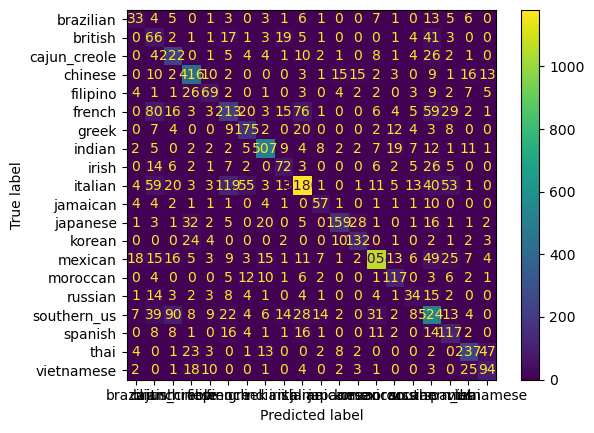

In [213]:
ConfusionMatrixDisplay.from_predictions(y_val, predictions)
plt.show()

The numbers in the diagonal are all the times when the predicted cuisine for a recipe was the same as the actual one.  
Now we can define accuracy as the sum of all the values in the diagonal (these are the observations we predicted correctly) divided by the total number of observations in the table.  
The best accuracy would be 1.0 when all values are on the diagonal (no errors!), whereas the worst is 0.0 (nothing correct!):

In [215]:
correctPredictions = sum(mat[i][i] for i in range(len(mat)))
correctPredictions

5482

In [327]:
print(f"Accuracy: {correctPredictions / len(y_val):.2}")

Accuracy: 0.69


Which is the same value as above.

## A better model

A more accurate model can be built using a Support Vector Classifier (SVC).  
But first we need to convert the ingredients to numeric values and will do that using term frequency-inverse document frequency (TF-IDF).This is a common term weighting scheme in information retrieval, that has also found good use in document classification.
The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.
  
We can use the sklearn function TfidfVectorizer but since we have already vectorised using CountVectorizer, we can just transform the vectors (TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer).   
So we transform a count matrix to a normalized tf or tf-idf representation.

In [222]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

In [268]:
   # start transforming the count sparse matrix into TF-IDF matrix
vectoriser = TfidfTransformer(sublinear_tf=True)

In [269]:
  # for training set
x_tfidf_train = vectoriser.fit_transform(X_train.values)
x_tfidf_train.sort_indices()

In [270]:
  # for validation set
x_tfidf_val = vectoriser.fit_transform(X_val.values)
x_tfidf_val.sort_indices()

In [ ]:
label_encoder = LabelEncoder()


In [271]:
  # same for the target cuisine labels
y_train_enc = label_encoder.fit_transform(y_train.values)
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

In [272]:
y_val_enc = label_encoder.fit_transform(y_val.values)
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

Build and apply the SV Classifier

In [258]:
estimator = SVC(C=250, # penalty parameter, setting it to a larger value 
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value, not tuned yet
	 			 gamma=1.4, # kernel coefficient, not tuned yet
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	 			 probability=False, # no need to enable probability estimates
	 			 cache_size=1000, # 200 MB cache size
	 			 class_weight=None, # all classes are treated equally 
	 			 verbose=False, # print the logs 
	 			 max_iter=-1, # no limit, let it run
	 			 decision_function_shape='ovr', # will use one vs rest explicitly 
	 			 random_state=None)
classifier = OneVsRestClassifier(estimator, n_jobs=-1)

In [273]:
classifier.fit(x_tfidf_train, y_train_enc)


OneVsRestClassifier(estimator=SVC(C=250, cache_size=1000, coef0=1, gamma=1.4),
                    n_jobs=-1)

Predict on validation set:

In [274]:
y_pred = label_encoder.inverse_transform(classifier.predict(x_tfidf_val))
y_actual = label_encoder.inverse_transform(y_val_enc)

print(f'accuracy score on val data: {accuracy_score(y_actual, y_pred)}')

accuracy score on val data: 0.7967551251414916


The accuracy on the validation set is better than the baseline, around 80%  

The part below is to predict the test dataset, part of the original dataset.

In [347]:
test = pd.read_json("../datasets/whats-cooking-kernels-only/test.json")


In [348]:
test.head(3)

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."


In [349]:
test['x'] = test['ingredients'].apply(lambda ingredients: preprocess(ingredients))
test.head(3)

,id,ingredients,x
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",baking powder egg all purpose flour raisin mil...
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",sugar egg yolk corn starch cream tartar banana...
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",sausage link fennel bulb frond olive oil cuban...


In [293]:
#cv.fit(test.x)

CountVectorizer(lowercase=False, max_features=500)

In [350]:
X_test = pd.DataFrame(cv.transform(test.x).toarray())

In [351]:
X_test.shape

(9944, 500)

In [353]:
X_tfidf_test = vectoriser.fit_transform(X_test.values)

In [354]:
X_tfidf_test.sort_indices()

In [355]:
X_tfidf_test.shape

(9944, 500)

In [356]:
print ("Predict on test data ... ")
Y_test = classifier.predict(X_tfidf_test)

Predict on test data ... 


In [357]:
Y_pred = label_encoder.inverse_transform(Y_test)

In [359]:
test['cuisine'] = Y_pred
test[['id', 'cuisine']].to_csv('~/Downloads/submission.csv', index=False)
test[['id', 'cuisine']].head()


,id,cuisine
0,18009,filipino
1,28583,southern_us
2,41580,italian
3,29752,southern_us
4,35687,moroccan


[Score was 0.7859](https://www.kaggle.com/code/mashimo/simple-step-by-step-model)